# Boosted Trees Regression (BQML)

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [40]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA' #add proj name and dataset

In [3]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = project_name #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


# data processing libraries
import numpy as np
import pandas as pd


# modeling and metrics
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

!pip install relativeImp
from relativeImp import relativeImp
!pip install shap
import shap

# visutalization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.9 MB/s eta 0:00:00


## 1) Import dataset

Import the data using the bigquery magics (%% command).
Pulls all of the data from the cleaned data table and stores into a dataframe "df"

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update project name

In [42]:
#update file name
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)

df = df_raw.drop(columns = ['DIV_WYG_PPl21_0p0_0d0_12']).copy()
#df = df_raw.copy()

df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,...,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,DIV_PLANPAGE_ESSl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,10/13/2023,729,-1.108161,0.178209,-0.774452,0.627772,-0.264759,-0.146654,-0.311050,1.422696,...,0.152846,-0.690469,-0.624894,-0.189886,-1.329793,-0.263140,-0.970183,0.060408,-0.310528,0
1,10/14/2023,936,-0.591641,-1.339583,-0.210658,-0.060092,1.589453,-0.647853,0.225988,0.828675,...,-0.092741,-0.717841,-0.191100,-0.421855,-0.885066,-0.368436,-0.970183,-0.082952,0.649707,0
2,10/15/2023,787,-1.532171,-1.826123,-1.843573,-1.182772,-1.070458,-1.485678,0.973487,-1.001415,...,-0.817821,-0.772585,-0.320066,-1.336846,-1.405619,-1.460062,-0.970183,-0.144391,-1.107704,0
3,10/16/2023,1030,-0.780518,-1.196795,-0.373532,0.178700,-0.684164,-0.640373,-1.523014,-0.602030,...,-0.080364,-0.714270,1.079373,1.429066,0.473788,0.647186,0.539693,0.026275,-1.216410,0
4,10/17/2023,950,-0.965540,-0.985256,-0.277478,-1.161387,-0.375129,-0.902193,-1.312554,0.123433,...,2.984049,-0.288221,0.529403,1.571362,-0.316369,0.114966,-0.788998,-0.977240,-1.216410,0


In [43]:
df.columns

Index(['Date', 'A_OC_GOOGLE_SHOPPING', 'C_DIV_BUY_CONNECTEDl21_0p0_0d0_12',
       'C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12', 'C_DIV_BUY_PREMIUMl21_0p0_0d0_12',
       'C_DIV_BUY_SSl21_0p0_0d0_06', 'C_DIV_CONN_DATAl21_0p0_0d0_06',
       'C_DIV_CONN_REMOTEl21_0p0_0d0_12', 'C_DIV_CONN_TRYl21_0p0_0d0_06',
       'C_DIV_GETNOW_CONNl21_0p0_0d0_06', 'C_DIV_GETNOW_ESSl21_0p0_0d0_12',
       'C_DIV_GETNOW_PREMl21_0p0_0d0_12', 'C_DIV_GETNOW_SSl21_0p0_0d0_12',
       'C_PP_PKG_APP_ACCESSl21_0p0_0d0_12', 'C_PP_PKG_CONNECTEDl21_0p0_0d0_12',
       'C_PP_PKG_ESSl21_0p0_0d0_12', 'C_PP_PKG_PREMl21_0p0_0d0_12',
       'C_PP_PKG_REMOTEl21_0p0_0d0_0', 'C_PP_PKG_SCl21_0p0_0d0_12',
       'C_PP_PKG_SSl21_0p0_0d0_12', 'DIV_GMOC_SHOP_ESSl21_0p0_0d0_0',
       'DIV_GMOC_SHOP_SSl21_0p0_0d0_0', 'DIV_PKG_CONN_SERVICESl21_0p0_0d0_06',
       'DIV_PLANPAGE_ESSl21_0p0_0d0_0', 'OC_APP_Accessl21_0p0_0d0_12',
       'OC_PAGE_PREFl21_0p0_0d0_06', 'OC_PAGE_PREFPLl21_0p0_0d0_12',
       'OC_PAGE_PREMl21_0p0_0d0_12', 'SC_BUY

In [44]:
df.describe()

,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,C_DIV_GETNOW_ESSl21_0p0_0d0_12,...,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,DIV_PLANPAGE_ESSl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,1437.351648,0.033275,0.051925,0.071950,0.037940,0.014379,0.112947,-0.006564,-0.002954,-0.011555,...,0.019907,-0.037689,0.088687,0.007363,0.058457,0.109532,0.003438,0.033851,-0.024628,0.076923
std,668.428578,0.993724,1.013226,1.034049,1.040883,0.998197,1.135214,1.008677,0.984529,0.979169,...,0.982110,0.990097,1.065132,0.986404,1.011399,1.091424,0.980057,1.009604,0.986512,0.267946
min,354.000000,-2.094947,-1.826123,-1.856102,-2.052403,-2.207267,-1.740018,-2.016509,-2.379038,-0.830356,...,-2.298435,-0.821973,-2.136245,-2.267408,-2.289055,-2.164775,-0.970183,-2.001235,-1.216410,0.000000
25%,1029.500000,-0.622478,-0.599197,-0.605314,-0.762212,-0.617942,-0.644113,-0.575940,-0.768862,-0.489050,...,-0.635369,-0.709213,-0.558279,-0.635836,-0.711147,-0.635408,-0.788998,-0.632495,-1.107704,0.000000
50%,1249.000000,0.001972,0.035420,-0.043608,-0.060092,-0.115760,-0.154135,-0.049788,-0.071203,-0.338373,...,-0.002628,-0.611923,-0.122887,-0.051886,0.178908,0.140619,-0.215245,-0.082952,-0.256175,0.000000
75%,1715.500000,0.707369,0.662105,0.622505,0.702618,0.728569,0.661249,0.599738,0.621400,-0.053000,...,0.562598,0.582621,0.583227,0.573948,0.896248,0.780815,0.584989,0.623605,0.649707,0.000000
max,4317.000000,3.301536,3.123891,5.790618,3.012131,2.483448,4.446423,2.787805,2.498253,3.644293,...,2.984327,3.415908,3.235552,2.727987,2.356806,3.223860,3.559445,4.484065,2.515824,1.000000


In [45]:
df.head()

,Date,A_OC_GOOGLE_SHOPPING,C_DIV_BUY_CONNECTEDl21_0p0_0d0_12,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_12,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_06,C_DIV_GETNOW_CONNl21_0p0_0d0_06,...,DIV_PKG_CONN_SERVICESl21_0p0_0d0_06,DIV_PLANPAGE_ESSl21_0p0_0d0_0,OC_APP_Accessl21_0p0_0d0_12,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREFPLl21_0p0_0d0_12,OC_PAGE_PREMl21_0p0_0d0_12,SC_BUYNOWl21_0p0_0d0_12,SC_HOMEPAGEl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06,Is_Holiday
0,10/13/2023,729,-1.108161,0.178209,-0.774452,0.627772,-0.264759,-0.146654,-0.311050,1.422696,...,0.152846,-0.690469,-0.624894,-0.189886,-1.329793,-0.263140,-0.970183,0.060408,-0.310528,0
1,10/14/2023,936,-0.591641,-1.339583,-0.210658,-0.060092,1.589453,-0.647853,0.225988,0.828675,...,-0.092741,-0.717841,-0.191100,-0.421855,-0.885066,-0.368436,-0.970183,-0.082952,0.649707,0
2,10/15/2023,787,-1.532171,-1.826123,-1.843573,-1.182772,-1.070458,-1.485678,0.973487,-1.001415,...,-0.817821,-0.772585,-0.320066,-1.336846,-1.405619,-1.460062,-0.970183,-0.144391,-1.107704,0
3,10/16/2023,1030,-0.780518,-1.196795,-0.373532,0.178700,-0.684164,-0.640373,-1.523014,-0.602030,...,-0.080364,-0.714270,1.079373,1.429066,0.473788,0.647186,0.539693,0.026275,-1.216410,0
4,10/17/2023,950,-0.965540,-0.985256,-0.277478,-1.161387,-0.375129,-0.902193,-1.312554,0.123433,...,2.984049,-0.288221,0.529403,1.571362,-0.316369,0.114966,-0.788998,-0.977240,-1.216410,0


Set KPI and date columns

In [46]:
kpi_col = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
date_col = "Date" #@param {type:"string"}

## 2) Run the RBA Model in BQML

In [47]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

This model also includes a train/test split of 90/10 using the "data_split_method", "data_split_eval_fraction", and "data_split_col" parameters.

Since this data is time series, we use a sequential split with the date column as the reference point.

We suggest using a train/test split to validate model performance, but for attribution results we suggest running the model on the full dataset.

In [48]:
# %%bigquery
# CREATE OR REPLACE MODEL `.RBA_demo.RBA_model`  #update project name
# OPTIONS (model_type='boosted_tree_regressor',
#         #data_split_method = 'SEQ', #use these options for train/test splits
#         #data_split_eval_fraction = 0.1,
#         #data_split_col = 'date',
#         input_label_cols = ['y1'],
#         enable_global_explain = True)
# AS SELECT * EXCEPT(date)
#     FROM `.RBA_demo.cleaned_data`
#     #ORDER BY date; #update project name

In [49]:
import xgboost as xgb

# Prepare your features and target variable
X_all = df.drop(columns = [kpi_col,date_col], axis=1)  # Assuming 'y1' is your target variable
y = df[kpi_col]

# Create the XGBoost model
model_all = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_all.fit(X_all, y)

# Evaluate the model on the test data
#y_pred = model_all.predict(X_all)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
# Calculate the index for splitting the data (e.g., last 10% for testing)
split_index = int(len(df) * 0.9)

# Split the data into training and testing sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separate features and target variable for both sets
X_train = train_df.drop([kpi_col, date_col], axis=1)
y_train = train_df[kpi_col]
X_test = test_df.drop([kpi_col, date_col], axis=1)
y_test = test_df[kpi_col]

# Create the XGBoost model
model_train = xgb.XGBRegressor(objective ='reg:squarederror', enable_categorical=True)

# Fit the model
model_train.fit(X_train, y_train)

# Evaluate the model on the test data
#y_pred_test = model.predict(X_test)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

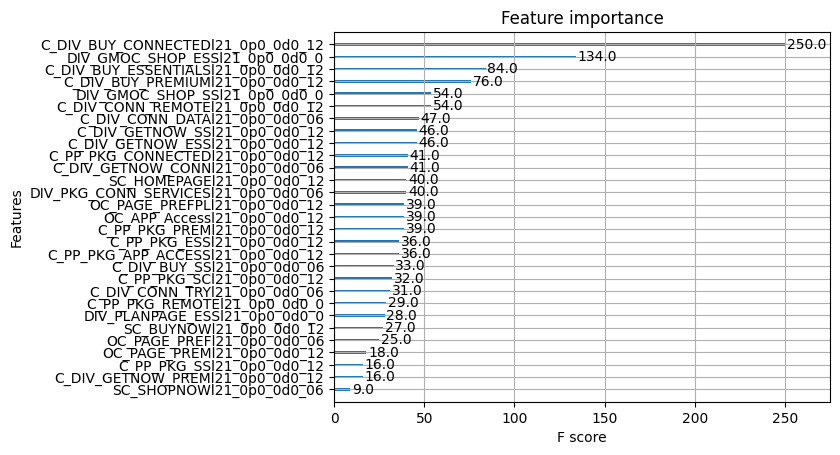

In [51]:
xgb.plot_importance(model_all)

### 2.1) Print the model evaluation metrics

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Call the model evaluation metrics from the model and save to a dataframe "evaluation_metrics".

For linear regression models The ML.EVALUATE function returns: mean absolute error,mean squared erorr, mean squared log error, median absolute error, r-squared, and explained variance metrics.

In [ ]:
# %%bigquery evaluation_metrics
# SELECT *
# FROM ML.EVALUATE(MODEL `.RBA_demo.RBA_model`) #update project name

In [ ]:
# evaluation_metrics

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred_test = model_train.predict(X_test)

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)


# Print the metrics
print(f"Model Fit Test")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print()



# Assuming 'model' is your trained model, and you have 'X_test' and 'y_test'
y_pred = model_all.predict(X_all)

# Calculate the metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)


print(f"Model Fit All")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")



Model Fit Test
Mean Absolute Error (MAE): 114.3509521484375
Mean Squared Error (MSE): 21243.217790701987
Root Mean Squared Error (RMSE): 145.75053272870733
R-squared (R2): 0.6052474478169907

Model Fit All
Mean Absolute Error (MAE): 0.0004148378476991758
Mean Squared Error (MSE): 3.389707142180139e-07
Root Mean Squared Error (RMSE): 0.0005822119152147385
R-squared (R2): 0.999999999999233


WARNING: make sure evaluation metrics displayed in Colab match the BQ UI.

### 2.2) Visualize model fit

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

Select the predicted conversions (y1) of the model and actual conversions from the data (y1) using the ML.PREDICT function

In [ ]:
# %%bigquery model_predictions
# SELECT
#   *
# FROM
#   ML.PREDICT(MODEL `.RBA_demo.RBA_model`, #update project name
#     (
#     SELECT
#         *
#     FROM
#       `.RBA_demo.cleaned_data`
#       ORDER BY date)); #update project name

Visualize the model fit by comparing predicted vs. actual data.

In [53]:
results = pd.DataFrame()
results['actual'] = df[kpi_col]
results['predicted'] = y_pred

In [54]:
fig = px.line(results.sort_index())
fig.show()

## 3) Calculate contribution of each digital media tactic on conversions

To determine feature attribution, we use BQML's Global Explainability methodology. ML.GLOBAL_EXPLAIN provides explanations for the entire model by aggregating the local explanations of the evaluation data

In [ ]:
# %%bigquery feature_importance
# SELECT
#   *
# FROM
#   ML.GLOBAL_EXPLAIN(MODEL `RBA_demo.RBA_model`);

In [ ]:
#feature_importance

In [ ]:
# sum_feature_imp = feature_importance.attribution.sum()
# scale_factor = 0.99 # pulled from BQ UI

# feature_importance['attribution %'] = feature_importance.attribution / (sum_feature_imp / scale_factor)
# feature_importance.sort_values(by = 'attribution %', ascending = False)

In [ ]:
# feature_importance['attribution %'].sum()

In [56]:
# For xgboost
importances = model_all.feature_importances_

feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})


In [57]:
sum_importance = feature_importance.importance.sum()
scale_factor = 0.99  # Adjust as needed

feature_importance['attribution %'] = feature_importance.importance / (sum_importance / scale_factor)
feature_importance.sort_values(by='attribution %', ascending=False, inplace=True)


In [58]:
total_scaled_importance = feature_importance['attribution %'].sum()
print(total_scaled_importance)


0.99000007


## 4) Export Final Results

In [59]:
final_results_df = feature_importance[['feature','attribution %']]
final_results_df.to_csv('rba_final_output_boosted.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_boosted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>